# IMPORTS

In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
%matplotlib inline

# FRAMEWORK

In [2]:
class Tic:  
    WINNING_CONDITIONS = np.array([[1, 2, 3],
                                    [4, 5, 6],
                                    [7, 8, 9],
                                        
                                    [1, 4, 7],
                                    [2, 5, 8],
                                    [3, 6, 9],

                                    [1, 5, 9],
                                    [7, 5, 3]])
    
    def __init__(self, state=np.array([])):
        self.state = state
        self.options = np.setdiff1d(np.arange(1,10), self.state)
        self.player = 'circles' if len(self.state) % 2 == 0 else 'crosses'
        self.winner = self.check_winner()
    
    
    def check_winner(self):        
        for condition in self.WINNING_CONDITIONS:
            if sum([1 for j in condition if j in self.state[::2]]) == 3:
                return 'crosses'
            elif sum([1 for j in condition if j in self.state[1::2]]) == 3:
                return 'circles'
    
    
    def choose(self, choice, show=False):
        self.state = np.append(self.state, choice)
        self.options = np.setdiff1d(np.arange(1,10), self.state)
        self.winner = self.check_winner()
        
        if show:
            self.show()

    
    def show(self):
        crosses = self.state[::2]
        circles = self.state[1::2]
        
        board = np.chararray(9)
        for cross in crosses:
            board[int(cross)-1] = 'X'
        for circle in circles:
            board[int(circle)-1] = 'O'
        for option in self.options:
            board[int(option)-1] = '_'
        
        print(board.reshape((3,3)))
        if self.winner is not None:
            print(f'{self.winner} wins')
        print()
         

class Node:
    def __init__(self, action=None, parent=None, player='crosses', strategy='random', constant=0.01):
        self.action = action
        self.player = player
        self.parent = parent
        self.strategy = strategy
        self.constant = constant
        self.children ={}
        
        self.rewards = []
        self.ucb_hist = []
        self.mean_rewards = [0]
    
    
    def ucb(self, i, c):
        if len(self.rewards) > 0:
            self.ucb_hist.append(self.mean_rewards[-1] + c*np.sqrt(np.log(i)/(2*len(self.rewards))))
            return self.ucb_hist[-1]
        else:
            self.ucb_hist.append(1.5)
            return self.ucb_hist[-1]

            
class MCTS:   
    def __init__(self, state=Tic(), strategy={'crosses': ('ucb', 1), 
                                              'circles': ('random', 0)}):
        self.strategy = strategy
        self.root_state = copy.deepcopy(state)            
        self.root = Node(player=state.player, 
                         strategy=self.strategy['crosses'][0],
                         constant=self.strategy['crosses'][1])
        self.i = 1

        
    def search(self, n=10):
        for i in range(n):
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.backup(node, outcome)
            self.i += 1
        
        
    def select_node(self, show=False):
        node = self.root
        state = copy.deepcopy(self.root_state)

        while len(node.children) != 0:
            
            node = self.get_next_node(node)
            state.choose(node.action)
            
            if show:
                state.show()
            
            if len(node.rewards) == 0:
                return node, state
        
        if self.expand(node, state):
            node = np.random.choice(list(node.children.values()))
            state.choose(node.action)
            
        return node, state
    
    
    def get_next_node(self, node):
        children = list(node.children.values())
        
        if node.strategy == 'ucb':
            values = [n.ucb(self.i, node.constant) for n in children]
            next_node = children[np.argmax(values)]
            
        elif node.strategy == 'greedy':
            if np.random.uniform() > node.constant:
                values = [n.mean_rewards[-1] for n in children]
                next_node = children[np.argmax(values)]
            else:
                next_node = np.random.choice(children)
                
        else:  # node.strategy == 'random':
            next_node = np.random.choice(children)
        
        return next_node            
    
    
    def expand(self, parent, state):
        if (state.winner is not None) or (len(state.options) == 0):
            return False
        
        else:
            player = 'crosses' if parent.player == 'circles' else 'circles'
            for action in state.options:

                parent.children[action] = Node(action, parent, player, 
                                               self.strategy[parent.player][0], 
                                               self.strategy[parent.player][1])
                
            return True

    
    def roll_out(self, state, show=False):
        actions = state.options

        while (state.winner is None) and (len(state.options) > 0):
            action = np.random.choice(actions)
            state.choose(action)
            actions = np.delete(actions, np.where(actions==action))
            
            if show:
                state.show()
        
        return state.winner


    def backup(self, node, outcome):

        if outcome == 'crosses':
            reward = 1
        elif outcome == 'circles':
            reward = -1
        else:
            reward = 0
        
        while node is not None:
            if node.player == 'crosses':
                node.rewards.append(reward)
            else:
                node.rewards.append(reward*-1)
                
            node.mean_rewards.append(sum(node.rewards)/len(node.rewards))
            node = node.parent
                  

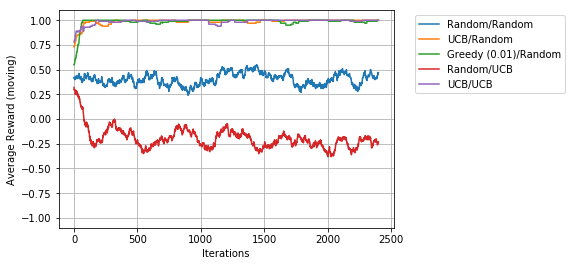

In [15]:
start = np.array([3, 2, 5, 7])
N = 2500
conv = 100
strategies = [{'crosses': ('random', 0), 'circles': ('random', 0)},
              {'crosses': ('ucb', 1), 'circles': ('random', 0)},
              {'crosses': ('greedy', 0.01), 'circles': ('random', 0)},
              {'crosses': ('random', 1), 'circles': ('ucb', 1)},
              {'crosses': ('ucb', 1), 'circles': ('ucb', 1)}]

results = np.zeros((len(strategies), N-conv))

for i, strategy in enumerate(strategies):

    m = MCTS(Tic(start), strategy=strategy)
    m.search(N)
    
    results[i, :] = -np.convolve(m.root.rewards[1:], np.ones(conv), 'valid') / conv
    
plt.plot(results[0, :], label='Random/Random')
plt.plot(results[1, :], label='UCB/Random')
plt.plot(results[2, :], label='Greedy (0.01)/Random')
plt.plot(results[3, :], label='Random/UCB')
plt.plot(results[4, :], label='UCB/UCB')

plt.xlabel('Iterations')
plt.ylabel('Average Reward (moving)')
plt.ylim(-1.1, 1.1)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

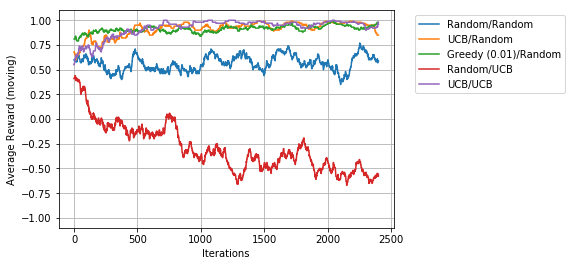

In [16]:
start = np.array([5, 2])
N = 2500
conv = 100
strategies = [{'crosses': ('random', 0), 'circles': ('random', 0)},
              {'crosses': ('ucb', 1), 'circles': ('random', 0)},
              {'crosses': ('greedy', 0.01), 'circles': ('random', 0)},
              {'crosses': ('random', 1), 'circles': ('ucb', 1)},
              {'crosses': ('ucb', 1), 'circles': ('ucb', 1)}]

results = np.zeros((len(strategies), N-conv))

for i, strategy in enumerate(strategies):

    m = MCTS(Tic(start), strategy=strategy)
    m.search(N)
    
    results[i, :] = -np.convolve(m.root.rewards[1:], np.ones(conv), 'valid') / conv
    
plt.plot(results[0, :], label='Random/Random')
plt.plot(results[1, :], label='UCB/Random')
plt.plot(results[2, :], label='Greedy (0.01)/Random')
plt.plot(results[3, :], label='Random/UCB')
plt.plot(results[4, :], label='UCB/UCB')

plt.xlabel('Iterations')
plt.ylabel('Average Reward (moving)')
plt.ylim(-1.1, 1.1)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

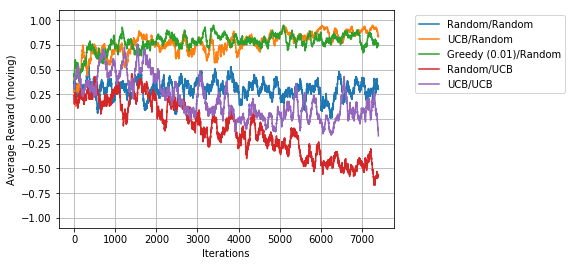

In [22]:
start = np.array([])
N = 7500
conv = 100
strategies = [{'crosses': ('random', 0), 'circles': ('random', 0)},
              {'crosses': ('ucb', 1), 'circles': ('random', 0)},
              {'crosses': ('greedy', 0.01), 'circles': ('random', 0)},
              {'crosses': ('random', 0), 'circles': ('ucb', 1)},
              {'crosses': ('ucb', 1), 'circles': ('ucb', 1)}]

results = np.zeros((len(strategies), N-conv))

for i, strategy in enumerate(strategies):

    m = MCTS(Tic(start), strategy=strategy)
    m.search(N)
    
    results[i, :] = -np.convolve(m.root.rewards[1:], np.ones(conv), 'valid') / conv
    
plt.plot(results[0, :], label='Random/Random')
plt.plot(results[1, :], label='UCB/Random')
plt.plot(results[2, :], label='Greedy (0.01)/Random')
plt.plot(results[3, :], label='Random/UCB')
plt.plot(results[4, :], label='UCB/UCB')

plt.xlabel('Iterations')
plt.ylabel('Average Reward (moving)')
plt.ylim(-1.1, 1.1)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()